# Schelling

 - n x n grid에서 agent들의 행복하게 느끼는 지수(min_to_be_happy)에 따라 어떻게 무리 짓는지를 시뮬레이션
 - agent들은 주변에 같은 그룹에 속한 agent들이 있을 때는 그 자리에 머물고 없어면 같은 그룹에 속한 agent들이 있는 곳으로 이동한다.
 - 이 모델은 인종별, 성향별, 성별등의 무리 짓기등의 시뮬레이션에 사용된다.
 
 소스 : <a href="https://github.com/mrchaos/julia_agents_examples" target="_blank">https://github.com/mrchaos/julia_agents_examples</a>

## 동작 환경
- Julia   : v1.7.2
- Agents  : v5.5.0
- InteractiveDynamics : v0.21.11
- GLMakie : v0.6.13
- CairoMakie : v0.8.13



- GLMakie를 사용하고 싶은 경우 설정에 대해서는 <a href="https://julialang.kr/?p=3684" target="_blank">https://julialang.kr/?p=3684</a> 를 참조

In [1]:
using Agents
using Random

In [2]:
@agent SchellingAgent GridAgent{2} begin
    mood::Bool
    group::Int
end

In [3]:
for (name, type) in zip(fieldnames(SchellingAgent),fieldtypes(SchellingAgent))
    println(name,"::",type)
end

id::Int64
pos::Tuple{Int64, Int64}
mood::Bool
group::Int64


In [4]:
function initialize(;numagents = 320, griddims = (20,20), min_to_be_happy = 3, seed = 125)
    space = GridSpaceSingle(griddims, periodic = false)
    properties = Dict(:min_to_be_happy => min_to_be_happy)
    rng = Random.MersenneTwister(seed)
    model = ABM(
        SchellingAgent,space;
        properties, rng, scheduler = Schedulers.Randomly()
    )
    
    for n in 1:numagents
        agent = SchellingAgent(n,(1,1),false,n < numagents / 2 ? 1 : 2 )
        add_agent_single!(agent,model)
    end

    return model
end

initialize (generic function with 1 method)

In [5]:
function agent_step!(agent, model)
    minhappy = model.min_to_be_happy
    count_neighbors_same_group = 0

    for neighbor in nearby_agents(agent, model)
        if agent.group == neighbor.group
            count_neighbors_same_group += 1
        end
    end

    if count_neighbors_same_group ≥ minhappy
        agent.mood = true
    else
        agent.mood = false
        move_agent_single!(agent, model)
    end
    return
end

agent_step! (generic function with 1 method)

In [6]:
# ENV["DISPLAY"]="localhost:10.0"
using InteractiveDynamics
using CairoMakie
CairoMakie.activate!()
# using GLMakie
# GLMakie.activate!()

In [7]:
model = initialize(; numagents = 300) 

AgentBasedModel with 300 agents of type SchellingAgent
 space: GridSpaceSingle with size (20, 20), metric=chebyshev, periodic=false
 scheduler: Agents.Schedulers.Randomly
 properties: min_to_be_happy

In [8]:
groupcolor(a) = a.group == 1 ? :blue : :orange
groupmarker(a) = a.group == 1 ? :circle : :rect

plotkwargs =(;ac = groupcolor, am = groupmarker, as = 10)

(ac = groupcolor, am = groupmarker, as = 10)

참고: https://juliadynamics.github.io/InteractiveDynamics.jl/stable/agents/

## Plot

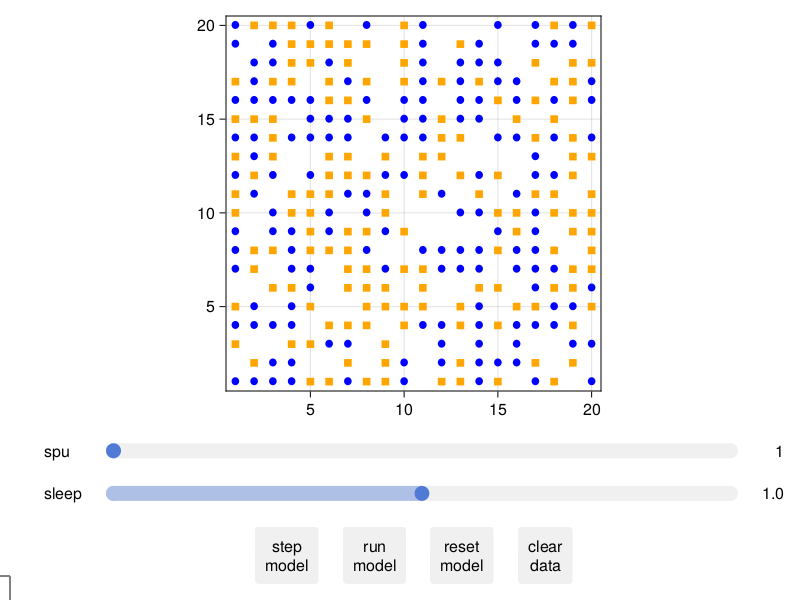

In [9]:
fig, ax, abmobs= abmplot(model;
agent_step! = agent_step!, model_step! = dummystep,
plotkwargs...)
fig

In [10]:
let
    ENV["DISPLAY"]="localhost:10.0"
    using GLMakie
    GLMakie.activate!()
    
    fig, ax, abmobs= abmplot(model;
    agent_step! = agent_step!, model_step! = dummystep,
    plotkwargs...)
   
    display(fig)
end

GLMakie.Screen(...)

## Video

In [11]:
model = initialize()

abmvideo(
    "schelling.mp4",
    model, agent_step!, dummystep;
    title = "Schelling", frames = 20,
    framerate = 1,
    plotkwargs...
)

<video width="auto" controls autoplay loop source src="schelling.mp4" type="video/mp4"/>

## Collecting data

In [12]:
using Statistics: mean

■ agent 정보(구조체의 필드)에 대해 수집

- n=10 : 모든 agent에 대해 0 ~ 10 step까지 진행시 pos, mood, group 데이터를 수집한다.
- 수집데이터 row는 agent# x step(n>=0) =  3 x 11 (0 step 포함) = 33 
- run!의 리턴은 (agent_dataframe, model_dataframe)

In [13]:
adata = [:pos, :mood, :group]
model = initialize(;numagents=3, )
agent_df, model_df = run!(model, agent_step!,10;adata)
agent_df[1:15,:]

,step,id,pos,mood,group
,Int64,Int64,Tuple…,Bool,Int64
1,0,1,"(14, 19)",0,1
2,0,2,"(14, 10)",0,2
3,0,3,"(7, 11)",0,2
4,1,1,"(6, 3)",0,1
5,1,2,"(1, 16)",0,2
6,1,3,"(2, 13)",0,2
7,2,1,"(14, 5)",0,1
8,2,2,"(20, 14)",0,2
9,2,3,"(15, 20)",0,2


■ agent 구조체와 function 조합의 데이터 수집
* adata의 원소로 들어가는 function의 파라미터는 agent임
* pos : (x,y)

In [14]:
x(agent) = agent.pos[1]
adata = [x, :mood, :group]
model = initialize(;numagents=3,min_to_be_happy=2)
agent_df, model_df = run!(model, agent_step!, 10; adata)
agent_df[1:15,:]

,step,id,x,mood,group
,Int64,Int64,Int64,Bool,Int64
1,0,1,14,0,1
2,0,2,14,0,2
3,0,3,7,0,2
4,1,1,6,0,1
5,1,2,1,0,2
6,1,3,2,0,2
7,2,1,14,0,1
8,2,2,20,0,2
9,2,3,15,0,2


■ agent 구조체와 function 조합의 데이터 수집 및 통계 데이터

In [15]:
adata = [(:mood,sum),(x, mean)]
agent_df, model_df = run!(model,agent_step!,10;adata)
agent_df

,step,sum_mood,mean_x
,Int64,Int64,Float64
1,0,0,13.6667
2,1,0,5.0
3,2,0,5.33333
4,3,0,8.0
5,4,0,15.0
6,5,0,10.0
7,6,0,15.3333
8,7,0,6.0
9,8,0,9.33333


■ agent 구조체와 function 조합의 데이터 수집 및 통계 그래프

In [16]:
let
    ENV["DISPLAY"]="localhost:10.0"
    using GLMakie
    GLMakie.activate!()
    
    model = initialize()
    params = Dict(:min_to_be_happy => 0:8)
    alabels = ["happy","avg. x"]
    fig, abmobs = abmexploration(model;
        agent_step! , model_step! = dummystep, params, plotkwargs...,
        adata, alabels, 
    )
    display(fig)
end

GLMakie.Screen(...)

위 코드의 결과 화면

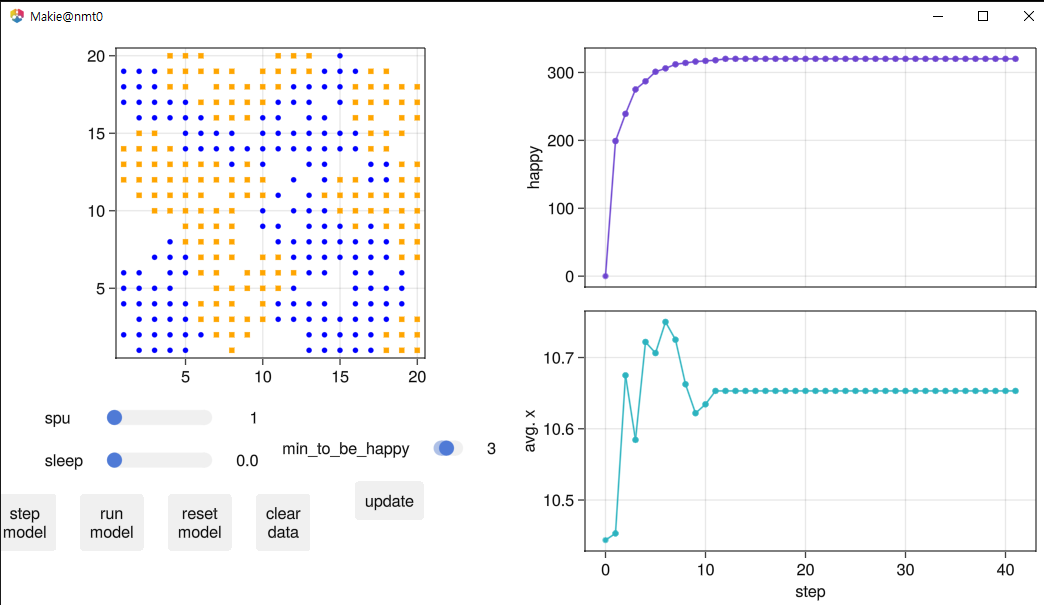

## Save / Load Model

1) model 생성 후 400 step 이후 안정된 model을 저장

2) 저장된 모델 로딩

3) 로딩된 모델에 100개의 agent 투입 후 40 step 진행

4) 저장된 모델 로딩

5) 로딩된 모델에 새로운 그룹 추가

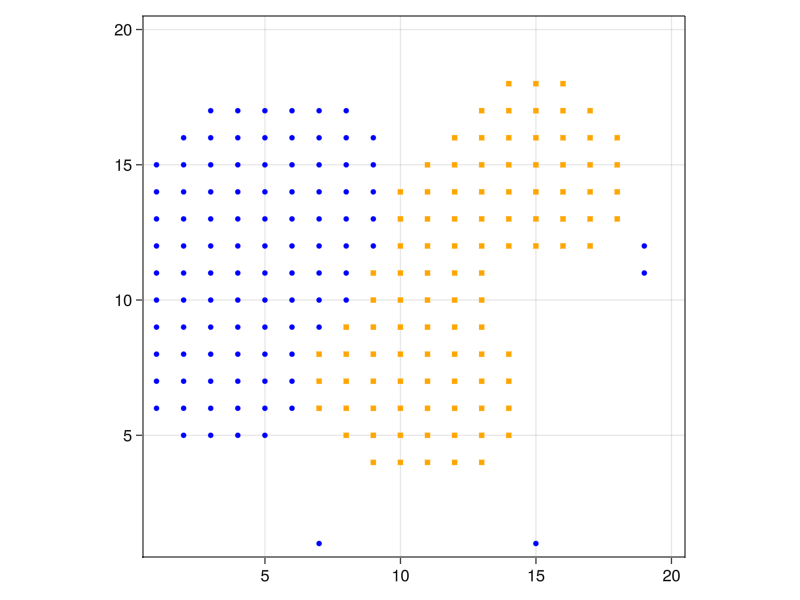

In [17]:
# agent 200개가 400step후에 안정화 된것으로 기대
model = initialize(numagents=200, min_to_be_happy=4, seed=42)
run!(model, agent_step!, 400)

fig, ax, abmobs = abmplot(model; plotkwargs...)
fig

In [18]:
#---
# save model : HDF5 기반 데이터 포맷으로 저장됨
#---
AgentsIO.save_checkpoint("schelling.jld2",model)

In [19]:
# model loading
model = AgentsIO.load_checkpoint("schelling.jld2"; scheduler = Schedulers.Randomly())

AgentBasedModel with 200 agents of type SchellingAgent
 space: GridSpaceSingle with size (20, 20), metric=chebyshev, periodic=false
 scheduler: Agents.Schedulers.Randomly
 properties: min_to_be_happy

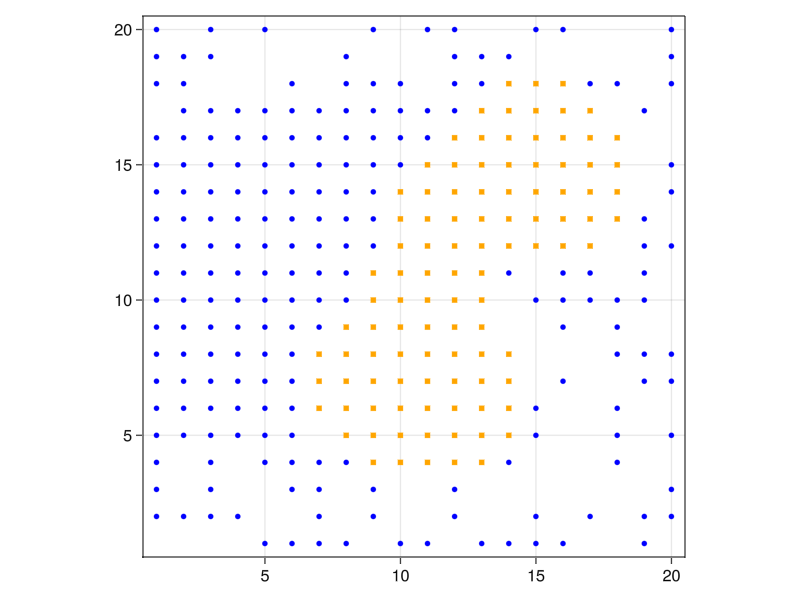

In [20]:
# 추가로 100개의 agent 투입 
for i in 1:100
    agent = SchellingAgent(nextid(model),(1,1),false,1)
    add_agent_single!(agent,model)
end
fig, ax, abmobs = abmplot(model; plotkwargs...)
fig

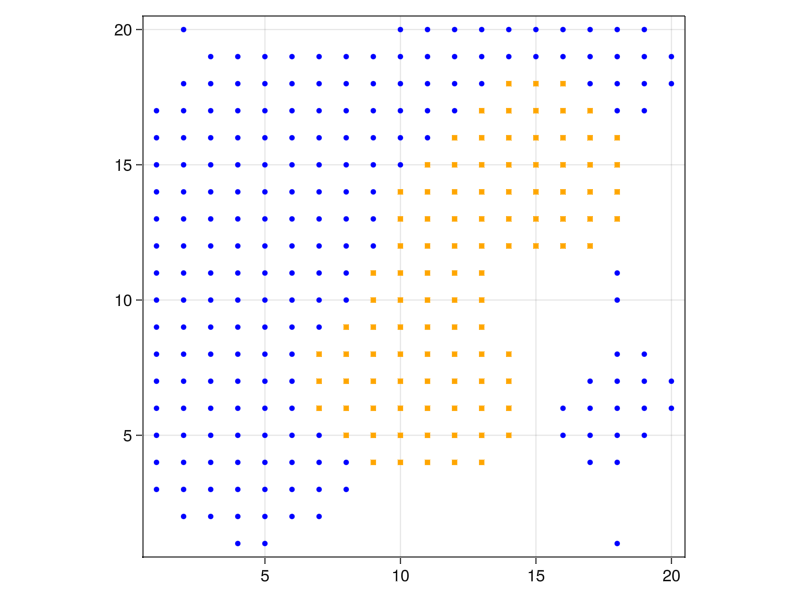

In [21]:
# model을 40 step 진행후 새로 추가된 agent들도 각자의 그룹을 찾아 안정화 되어감
run!(model,agent_step!,40)
fig, ax, abmobs = abmplot(model; plotkwargs...)
fig

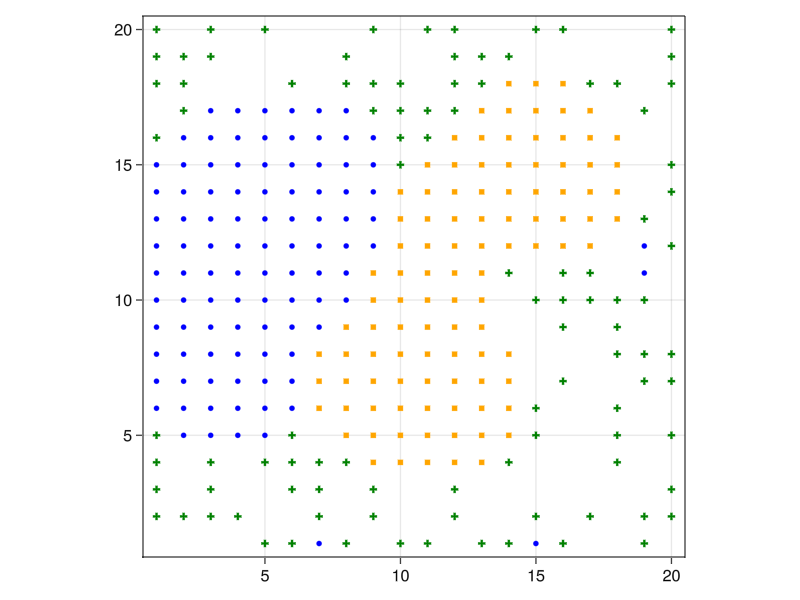

In [22]:
# 저장된 모델 로딩 후 새로운 그룹 추가

model = AgentsIO.load_checkpoint("schelling.jld2"; scheduler=Schedulers.Randomly())

# 새로운 그룹 추가
for i in 1:100
    agent = SchellingAgent(nextid(model),(1,1),false,3)
    add_agent_single!(agent,model)
end


# 새로운 그룹이 추가 되어 color 및 marker재정의
groupcolor(a) = (:blue, :orange, :green)[a.group]
groupmarker(a) = (:circle, :rect, :cross)[a.group]
#plotkwargs =(;ac = groupcolor, am = groupmarker, as = 10)

fig, ax, abmobs = abmplot(model; plotkwargs...)
fig

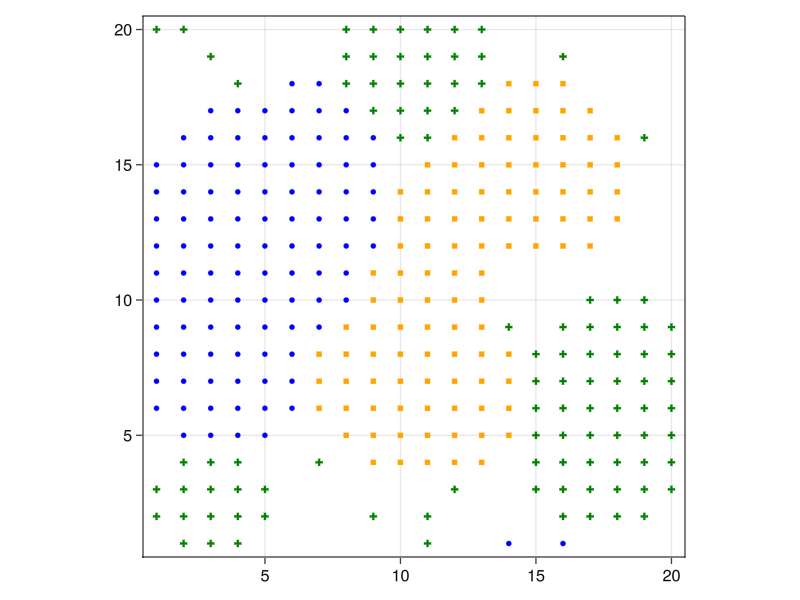

In [23]:
# 새로운 그룹 추가 후 40step 진행
run!(model,agent_step!,40)
fig, ax, abmobs = abmplot(model; plotkwargs...)
fig

In [24]:
#  저장된 모델파일 삭제
rm("schelling.jld2")

## Scanning parameter ranges

 - ABM의 동작에 대해 다양한 매개변수의 효과에 관심이 있는 경우
 - parameters에 들어가는 dict의 값이 Vector타입이면 expand된다.\
   아래의 경우 ":min_to_be_happy"와 ":numagents"는 Vector타입 이고\
   ":griddims"는 Tuple타입으로 ":min_to_be_happy"와 ":numagents"의 Vector size의\
   곱과 스텝(0스텝포함)의 곱만큼 데이터 row가 생긴다.\
   4*2*(3+1)  = 32

 - paramscan function은 병렬처리 가능하다.\
    parallet=true로 설정하면 됨

In [25]:
happyperc(moods) = count(moods) / length(moods)
adata = [(:mood, happyperc)]
parameters = Dict(
    :min_to_be_happy => collect(2:5),  # expanded
    :numagents => [200,300], # expanded
    :griddims => (20,20), # not vector = not expanded
)
agent_df, model_df = paramscan(parameters, initialize; adata, agent_step!,n=3)
agent_df

,step,happyperc_mood,min_to_be_happy,numagents
,Int64,Float64,Int64,Int64
1,0,0.0,2,200
2,1,0.575,2,200
3,2,0.805,2,200
4,3,0.865,2,200
5,0,0.0,3,200
6,1,0.3,3,200
7,2,0.495,3,200
8,3,0.57,3,200
9,0,0.0,4,200
